3-3-2017 Now makes use of new pyEclipseDVH_v2

6-3-2017 dropped a few cases which were outliters

8-3-2017 Compare dose metrics

In [1]:
%autosave 0  

Autosave disabled


In [2]:
import os
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyEclipseDVH_v2 import List_txt, Load_patient, get_dmin, get_dmax, get_d_metric, Load_files_to_df

from scipy import interpolate
from scipy import stats
from scipy.stats import wilcoxon  # must import explicitly

In [3]:
files = List_txt()
files

['Case11_AAA.txt',
 'Case11_AXB.txt',
 'Case12_AAA.txt',
 'Case12_AXB.txt',
 'Case13_AAA.txt',
 'Case13_AXB.txt',
 'Case17_AAA.txt',
 'Case17_AXB.txt',
 'Case1_AAA.txt',
 'Case1_AXB.txt',
 'Case22_AAA.txt',
 'Case22_AXB.txt']

In [4]:
df = Load_files_to_df(files)

Case11_AAA.txt loaded 	 patID:Case11 PlanID:AAA and number of structures is 24
Case11_AXB.txt loaded 	 patID:Case11 PlanID:AXB and number of structures is 24
Case12_AAA.txt loaded 	 patID:Case12 PlanID:AAA and number of structures is 21
Case12_AXB.txt loaded 	 patID:Case12 PlanID:AXB and number of structures is 21
Case13_AAA.txt loaded 	 patID:Case13 PlanID:AAA and number of structures is 26
Case13_AXB.txt loaded 	 patID:Case13 PlanID:AXB and number of structures is 26
Case17_AAA.txt loaded 	 patID:Case17 PlanID:AAA and number of structures is 21
Case17_AXB.txt loaded 	 patID:Case17 PlanID:AXB and number of structures is 21
Case1_AAA.txt loaded 	 patID:Case1 PlanID:AAA and number of structures is 25
Case1_AXB.txt loaded 	 patID:Case1 PlanID:AXB and number of structures is 25
Case22_AAA.txt loaded 	 patID:Case22 PlanID:AAA and number of structures is 25
Case22_AXB.txt loaded 	 patID:Case22 PlanID:AXB and number of structures is 25


In [5]:
df.head()

patID          Case11                                                      \
planID            AAA                                                       
Structure        BODY Foramen+3mm L Brachial plex  Oesophagus       Heart   
Dose (Gy)                                                                   
0.00       100.000000  100.000000      100.000000  100.000000  100.000000   
0.05        73.579636  100.000000       99.999730  100.000000  100.000000   
0.10        59.431917   99.500253       49.951929   91.745447   99.948371   
0.15        51.095246   91.731018       10.590058   83.622085   98.053264   
0.20        45.605092   85.412271        0.000000   77.838281   95.523973   

patID                                                                     \
planID                                                                     
Structure     Trachea Airway avoidance PTV CHEST     Lt_Lung     Foramen   
Dose (Gy)                                                                  
0.00       100.000000            100.0     100.0  100.000000  100.000000   
0.05        95.740093            100.0     100.0  100.000000  100.000000   
0.10        67.748328            100.0     100.0   99.901410   99.990019   
0.15        50.194165            100.0     100.0   96.984882   92.798198   
0.20        37.265473            100.0     100.0   91.856262   86.581735   

patID         ...            Case22                                            \
planID        ...               AXB                                             
Structure     ...     PseudoPTV-ITV    ITV Pseudo Ring   ribs R Brachial plex   
Dose (Gy)     ...                                                               
0.00          ...             100.0  100.0       100.0  100.0      100.000000   
0.05          ...             100.0  100.0       100.0  100.0      100.000000   
0.10          ...             100.0  100.0       100.0  100.0       88.845400   
0.15          ...             100.0  100.0       100.0  100.0       71.930095   
0.20          ...             100.0  100.0       100.0  100.0       28.644206   

patID                                                                 
planID                                                                
Structure    Artefact        temp       Liver Dose 50[%] Dose 100[%]  
Dose (Gy)                                                             
0.00       100.000000  100.000000  100.000000      100.0       100.0  
0.05       100.000000  100.000000   99.997635      100.0       100.0  
0.10        97.501684  100.000000   99.792447      100.0       100.0  
0.15        71.581485   99.999928   99.089665      100.0       100.0  
0.20        55.644619   99.999580   97.926520      100.0       100.0  

[5 rows x 284 columns]

In [6]:
df.columns.levels[0]

Index(['Case1', 'Case11', 'Case12', 'Case13', 'Case17', 'Case22'], dtype='object', name='patID')

In [7]:
df.columns.levels[2]

Index(['100[%]', '27Gy (Heart Tol)', '50[%]', 'Airway avoidance', 'Artefact',
       'BODY', 'Body', 'Both Lungs', 'Both Lungs-ITV', 'Bronchial tree',
       'Dose 100[%]', 'Dose 50[%]', 'Foramen', 'Foramen+3mm', 'Foramen+5mm',
       'GTV', 'Great vessels', 'Heart', 'ITV', 'Inner Ring', 'L Brachial plex',
       'Liver', 'Lt_Lung', 'Oesophagus', 'PTV CHEST', 'PTV ring 2-3cm',
       'Pseudo ITV', 'Pseudo PTV', 'Pseudo Ribs', 'Pseudo Ring',
       'PseudoPTV-ITV', 'R Brachial plex', 'Ribs', 'Rt Brachial plex',
       'Rt_Lung', 'Skin', 'Trachea', 'ribs', 'skin', 'temp'],
      dtype='object', name='Structure')

## Do some plotting

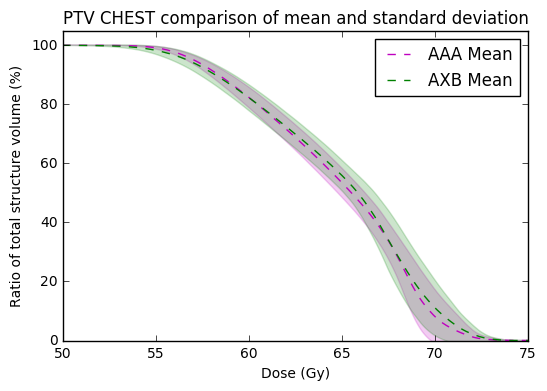

In [8]:
structure = 'PTV CHEST'
#structure = 'ITV'
AAA_df = df.xs(structure, level='Structure', axis=1).xs('AAA', level='planID', axis=1)
AXB_df = df.xs(structure, level='Structure', axis=1).xs('AXB', level='planID', axis=1)

xlimits = [50,75]
transparency = 0.2
height=4
width=6           # wwidth of figs
plt.figure(figsize=(width, height))
    
plt.fill_between(AAA_df.mean(axis = 1).index.values, (AAA_df.mean(axis = 1) - AAA_df.std(axis = 1)).values, (AAA_df.mean(axis = 1) + AAA_df.std(axis = 1)).values, color = 'm', alpha=transparency, interpolate=True)
plt.plot(AAA_df.mean(axis = 1), color = 'm', label = 'AAA Mean', ls = '--') # , 

plt.fill_between(AXB_df.mean(axis = 1).index.values, (AXB_df.mean(axis = 1) - AXB_df.std(axis = 1)).values, (AXB_df.mean(axis = 1) + AXB_df.std(axis = 1)).values, color = 'g', alpha=transparency, interpolate=True)
plt.plot(AXB_df.mean(axis = 1), color = 'g', label = 'AXB Mean', ls = '--') # 

#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.legend()
plt.ylim([0,105])
plt.xlim(xlimits)
plt.title(structure + ' comparison of mean and standard deviation')
plt.xlabel('Dose (Gy)')
plt.ylabel('Ratio of total structure volume (%)')

## Single case

In [9]:
AAA_df.head()

patID,Case11,Case12,Case13,Case17,Case1,Case22
Dose (Gy),,,,,,
0.00,100.0,100.0,100.0,100.0,100.0,100.0
0.05,100.0,100.0,100.0,100.0,100.0,100.0
0.10,100.0,100.0,100.0,100.0,100.0,100.0
0.15,100.0,100.0,100.0,100.0,100.0,100.0
0.20,100.0,100.0,100.0,100.0,100.0,100.0


(50, 75)

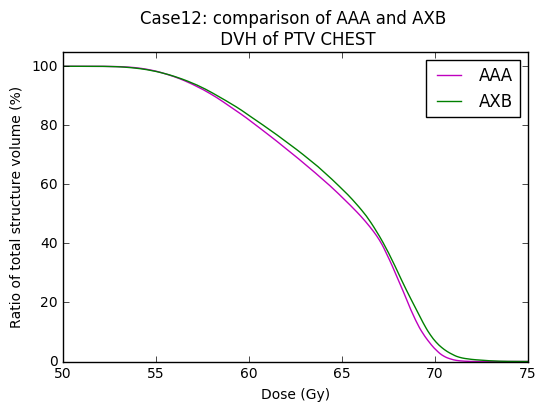

In [10]:
structure = 'PTV CHEST'
patient = 'Case12'
AAA_df = df.xs(structure, level='Structure', axis=1).xs(patient, level='patID', axis=1)['AAA']
AXB_df = df.xs(structure, level='Structure', axis=1).xs(patient, level='patID', axis=1)['AXB']

plt.figure(figsize=(width, height))
plt.plot(AAA_df, c='m')
plt.plot(AXB_df, c='g')
plt.legend()

plt.title(patient + ': comparison of AAA and AXB \n DVH of ' + structure)
plt.xlabel('Dose (Gy)')
plt.ylabel('Ratio of total structure volume (%)')
plt.ylim([0,105])
plt.xlim(xlimits)

In [15]:
get_d_metric(AAA_df, 95)

56.566103675333487

In [16]:
get_d_metric(AXB_df, 95)

56.677321084404618